### Pipeline optimization 
* Objective:
 * Build a stack of numpy arrays depicting the cost distance away from biogas sources
 
* Requirements - Packages
 * NumPy, Pandas, Scikit-Image

* Requirements - Data:
 * CSV of biogas sources, including coordinates and biogas production potential (MMBtu)
 * Cost surface for building pipelines
 
* Output: 
 * Stacked NumPy array

In [22]:
#Import packages
import numpy as np
import pandas as pd
from skimage import graph
from osgeo import gdal, osr
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Read in cost surface
ds =  gdal.Open('../data/MIT_Surface_Subset/MIT_CostSurface_500m.img')
#Get the raster projection
ds_prj = ds.GetProjection()
#Get raster attributes
llx, x_size, x_angle, lly, y_angle, y_size = ds.GetGeoTransform()
#Extract Band1 as the cost array
arrCost = np.array(ds.GetRasterBand(1).ReadAsArray()) / 100
#Print info
print("Lower left coordinate = ({0:.8f},{1:.8f})".format(llx,lly))
print("Pixel size is {0:.8f}(x), {1:.8f}(y)".format(x_size,y_size))
print("Values range from {} to {}".format(arrCost.min(),arrCost.max()))

Lower left coordinate = (1502530.32985527,-361423.20573852)
Pixel size is 500.00000000(x), -500.00000000(y)
Values range from 0.0 to 3.0


In [3]:
#Set zero cost multiplier to high costs (10)
arrCost[arrCost == 0] = 10
arrCostEven = arrCost / arrCost

In [4]:
#Read in biogas sources (example: Duplin Co)
dfBG =  pd.read_excel('../data/DuplinCountySwineFarmEconomics.xlsx',
                         sheet_name='Duplin County Swine Farm Master').iloc[:,[11,12,-6,-4,-1]]
dfBG.sort_values(by='Total Potential Methane Yield (scf/h)',ascending=False,inplace=True)
dfBG.head()

,Farm Latitude,Farm Longitude,Total Potential Methane Yield (scf/h),Estimated Methane Production Cost ($/MMBtu),TEST ($/mi-MMBtu @15y)
141,34.8672,-78.1514,5450.830387,2.332976,0.019108
197,34.9131,-77.9531,5237.045262,2.630236,0.019736
163,34.8825,-78.1094,4274.978908,4.138270,0.023257
202,34.9228,-77.9597,3038.314870,6.675278,0.030653
116,34.8489,-78.1297,2948.403709,6.898455,0.031406


In [5]:
#Convert to a geopandas dataframe (for easy reprojecting)
geom = [Point(xy) for xy in zip(dfBG.iloc[:,1],dfBG.iloc[:,0])]
gdfBG = gpd.GeoDataFrame(dfBG, geometry = geom)
gdfBG.crs = {'init':'epsg:4326'}
gdfBG.to_file('../data/DuplinSites_LL.shp')

In [6]:
#gdfBG.to_file('../data/DuplinSites_LL.shp')

In [7]:
#Re-project the points to match the raster (takes a moment...)
#gdf2 = gdfBG.to_crs(ds_prj)
gdf2 = gpd.read_file('../data/DuplinSites_Prj.shp')
gdf2.shape

(464, 5)

In [8]:
gdf2.columns

Index(['Farm_Latit', 'Farm_Longi', 'Total_Pote', 'TEST____mi', 'geometry'], dtype='object')

In [35]:
#Iterate through all records and create a cost distance raster
cd_arrays = []

for i,r in gdf2.iterrows():
    print(".",end='')
    x = r.geometry.x
    y = r.geometry.y
    z = r[-2] / 1609.34 #Convert from miles to meters
    base_cost = r[-3]
    
    #Get array index from lat long
    xOffset = int(((x - llx)/x_size))
    yOffset = int(((y - lly)/y_size))

    #Create the minimum cost path (MCP) surface
    lc_graph = graph.MCP_Geometric(arrCost * z , sampling=(x_size,y_size))
    #Compute cost distances away
    cd_array = lc_graph.find_costs(starts=([(yOffset, xOffset)]))[0]
    #Add the initial cost to all cells
    cd_array = cd_array + base_cost
    #Add to stack of arrays
    cd_arrays.append(cd_array)
        
#Create a stack of all arrays
arrStack =np.stack(cd_arrays)

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [36]:
#Export lowest cost farm to geotiff
bands,height,width = arrStack.shape
drv = gdal.GetDriverByName("GTiff")
dsOut = drv.Create('../scratch/lowest_cost.tif',width,height,1,gdal.GDT_Float32)

arrFirst = arrStack[0]
arrFirst[arrCost == 10] = -9999.9
dsOut.GetRasterBand(1).WriteArray(arrFirst)
dsOut.GetRasterBand(1).SetNoDataValue(-9999.9)
dsOut.SetGeoTransform (ds.GetGeoTransform())
dsOut.SetProjection(ds_prj)
dsOut.FlushCache()

In [37]:
#Export min of all rasters to geotiff

#Reduce to minimum costs
arrMin = np.amin(arrStack,axis=0) 
print(arrMin.min())

#Create the data source object
bands,height,width = arrStack.shape
drv = gdal.GetDriverByName("GTiff")
dsOut = drv.Create('../scratch/min_cost_surface.tif',width,height,1,gdal.GDT_Float32)

#Set no data values 
arrMin[arrCost == 10] = -9999.9

#Write to the data source object
dsOut.GetRasterBand(1).WriteArray(arrMin)
dsOut.SetGeoTransform (ds.GetGeoTransform())
dsOut.SetProjection(ds_prj)
dsOut.GetRasterBand(1).SetNoDataValue(-9999.9)
dsOut.FlushCache()

-9999.9


In [38]:
#Get array index from lat long
dfBG['xOffset'] = gdf2['geometry'].apply(lambda x: int(((x.x - llx)/x_size)))
dfBG['yOffset'] = gdf2['geometry'].apply(lambda x: int(((x.y - lly)/y_size))) 

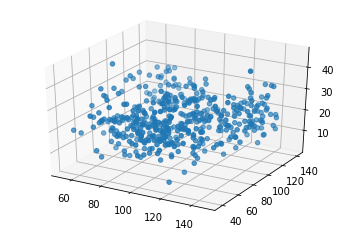

In [39]:
#Build 3d array of base cost values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(dfBG.xOffset,dfBG.yOffset,dfBG['Estimated Methane Production Cost ($/MMBtu)'], cmap='ocean')

plt.show()

In [40]:
arrMin.shape
y = np.arange(0,arrMin.shape[0])
x = np.arange(0,arrMin.shape[1])
X,Y  = np.meshgrid(x,y)
arrMin[arrCost == 10]=np.NaN

In [41]:
X1,Y1,Z1 = dfBG.iloc[0,[-2,-1,3]].values
X1m,Y1m = np.meshgrid(X1,Y1)

In [42]:
X2m,Y2m = np.meshgrid(dfBG.xOffset,dfBG.yOffset)
Z2 = dfBG['Estimated Methane Production Cost ($/MMBtu)']

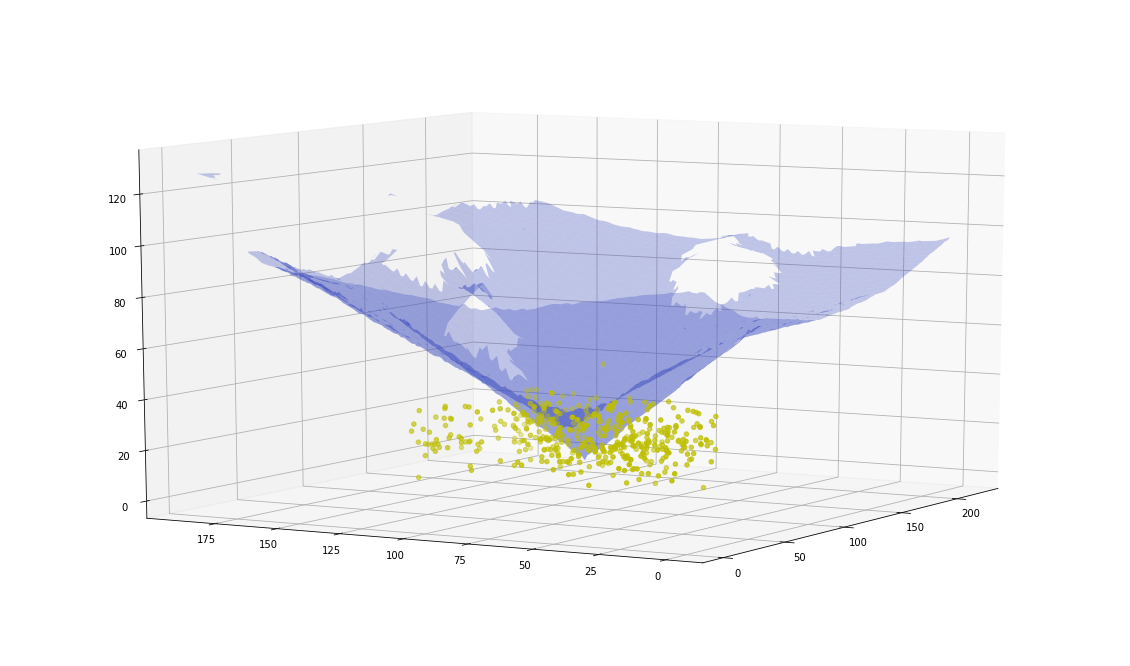

In [49]:
#3D plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter3D(X,Y,arrFirst)
#ax.contour3D(X,Y,arrMin,100)
ax.plot_surface(X,Y,arrMin,cmap=cm.coolwarm,linewidth=0,alpha=0.3)
#ax.scatter3D(X2m,Y2m,Z2,color='r')
ax.scatter3D(dfBG.xOffset,dfBG.yOffset,Z2,color='y')
#ax.scatter3D(dfBG.xOffset,dfBG.yOffset,dfBG['Estimated Methane Production Cost ($/MMBtu)'], cmap='ocean')
ax.view_init(10,210);

In [44]:
#Stack all the arrays
np.save('../data/DuplinStack500m.npy',arrStack)